In [1]:
# default_exp lowess

# Lowess

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from scipy import linalg

from timeit import timeit
import FEAutils as hlp

from moepy import eda

In [3]:
from ipypb import track

<br>

### LOESS Development

Before we go ahead any further we'll create some sample data for fitting and also define the fraction of the data over which we'll do the localised regression.

In [4]:
x = np.linspace(0, 5, num=26)
y = np.sin(x)

frac = 0.5

<br>

We can see that we've just created a simple sin curve

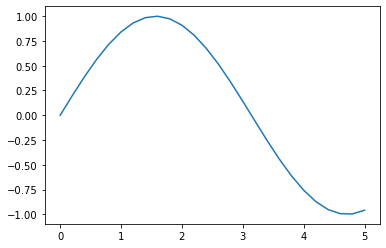

In [5]:
plt.plot(x, y)

<br>

#### Weights

In order to do localised regression we need to know what points are local, for this reason we'll start by creating a function for calculating the distance between one point and all of the other points

In [6]:
#exports
get_dist = lambda X, x: np.abs(X - x)

In [7]:
dist = get_dist(x, x[0])

dist

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

<br>

We've defined our selection of local based on the fraction of surrounding data, this means we need to calculate the distance around any given point that contains the fraction of data specified

In [8]:
#exports
def get_dist_threshold(dist, frac=0.4):
    frac_idx = int(np.ceil(len(dist)*frac))
    dist_threshold = sorted(dist)[frac_idx]
    
    return dist_threshold

In [9]:
dist_threshold = get_dist_threshold(dist, frac=frac)

dist_threshold

2.6

<br>
We'll now define a function that will map from the distances to their relative weights according to a tricube kernel

In [10]:
#exports
dist_to_weights = lambda dist, dist_threshold=1: (1 - ((np.abs(dist)/dist_threshold).clip(0, 1) ** 3)) ** 3

(0.0, 1.1)

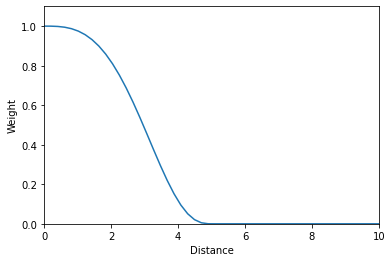

In [11]:
dist_threshold = 5
dist_sample = np.linspace(0, 10)

weights_sample = dist_to_weights(dist_sample, dist_threshold)

# Plotting
plt.plot(dist_sample, weights_sample)

plt.xlabel('Distance')
plt.ylabel('Weight')
plt.xlim(0, max(dist_sample))
plt.ylim(0, 1.1)

<br>

We can now use the distance matrix and threshold to create a vector of the relative weights of all data points for the local regression at a specified location

In [12]:
weights = dist_to_weights(dist, dist_threshold)

weights

array([1.        , 0.99980801, 0.99846479, 0.99482495, 0.98776226,
       0.97619149, 0.95909867, 0.93557909, 0.90488204, 0.86646079,
       0.82002586, 0.76559882, 0.70356317, 0.63470792, 0.56025877,
       0.4818903 , 0.40171203, 0.32221935, 0.24619951, 0.17658114,
       0.11621427, 0.06756635, 0.03231788, 0.01083964, 0.00153137,
       0.        ])

<br>

We'll wrap these steps into a single function and see how long it takes to compute

In [13]:
def get_weights(x, val, frac=0.4):
    dist = get_dist(x, val)
    dist_threshold = get_dist_threshold(dist, frac=frac)

    weights = dist_to_weights(dist, dist_threshold)
    
    return weights

In [14]:
timeit(lambda: get_weights(x, x[5]), number=10000)

0.5545429000000004

<br>

We've successfully calculated the weights with respect to a single point but we need to repeat this across each of values in our dataset.

In [15]:
#exports
def get_all_weights(x, frac=0.4):
    all_weights = []

    for i in range(len(x)):
        weights = get_weights(x, x[i], frac=frac)
        all_weights += [weights]

    all_weights = np.array(all_weights)
    
    return all_weights

In [16]:
all_weights = get_all_weights(x, frac=frac)

all_weights[:5, :5]

array([[1.        , 0.99863512, 0.98911574, 0.96358278, 0.91512916],
       [0.99826489, 1.        , 0.99826489, 0.98617531, 0.95385361],
       [0.98207661, 0.99774775, 1.        , 0.99774775, 0.98207661],
       [0.92116732, 0.97619149, 0.997003  , 1.        , 0.997003  ],
       [0.75907091, 0.89295331, 0.96743815, 0.99589042, 1.        ]])

<br>

Not too bad at all, we could now use this to weight the fitting of the polynomials in the LOESS. However, we've carried out most of these operations as part of for loops over vectors, what if we could store our data in matrices and do single operations over them?

Thankfully Numpy has lots of helpful functions to aid us in this. We'll start by creating a matrix with the distances, to do this we can reshape the vectors into matrices of shape (25, 1) and (1, 25), then deduct the matrix with only one row from the matrix with only one column.

In [17]:
#exports
vector_to_dist_matrix = lambda x: np.abs(x.reshape(-1, 1) - x.reshape(1, -1))

Text(69.58333333333334, 0.5, 'Regression Nodes')

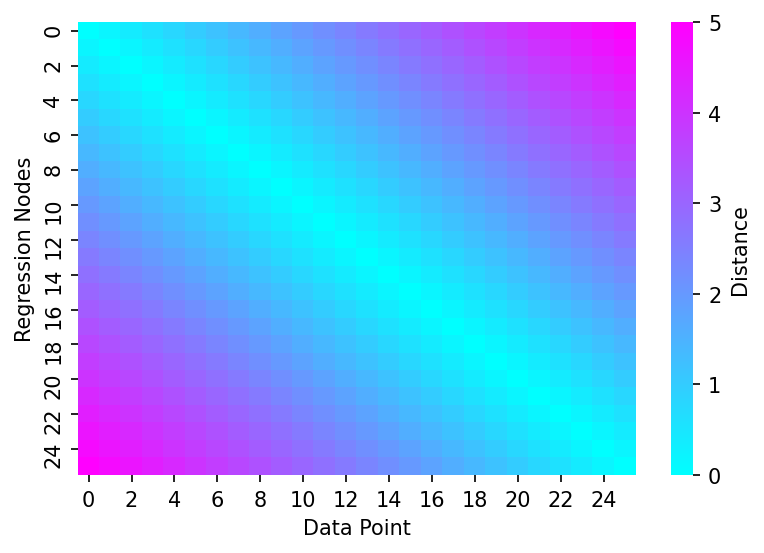

In [18]:
dist_matrix = vector_to_dist_matrix(x)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(dist_matrix, cmap='cool', cbar_kws={'label':'Distance'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

This approach brings an order of magnitude speed-up to the operation

In [19]:
%%timeit

timeit(lambda: [get_dist(x, x[x_idx]) for x_idx in range(len(x))], number=10000)

1.1 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit

timeit(lambda: vector_to_dist_matrix(x), number=10000)

58.2 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<br>

Now we need to calculate the distance threshold (max distance away from point of interest that is within the data fraction specified). 

<a href="https://gist.github.com/agramfort/850437">Alexandre Gramfort</a> lays out one approach to determine the distances using a list comprehension.

In [21]:
#exports
get_frac_idx = lambda x, frac: int(np.ceil(len(x) * frac)) - 1

In [22]:
gramfort_get_dist_thresholds = lambda x, frac_idx: [np.sort(np.abs(x - x[i]))[frac_idx] for i in range(len(x))]

frac_idx = get_frac_idx(x, frac)

timeit(lambda: gramfort_get_dist_thresholds(x, frac_idx), number=10000)

1.8261287999999993

<br>

Pretty quick, lets see if we could do better though. 

We'll try keeping the distance matrix intact rather than breaking it up in each iteration. This enables us to do the absolute conversion, sorting and indexing over a matrix rather than looping the operations over vectors. 

These changes gave us an order of magnitude speed-up.

In [23]:
#exports
get_dist_thresholds = lambda x, frac_idx, dist_matrix: np.sort(dist_matrix)[:, frac_idx]

In [24]:
dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)

timeit(lambda: get_dist_thresholds(x, frac_idx, dist_matrix), number=10000)

0.09520890000000293

<br>

Now we have both the distance matrix and thresholds we can start to calculate the weightings, the first step to this is scale and clip the distances based on their threshold values.

In [25]:
inv_linear_weights = np.clip(dist_matrix/dist_thresholds.reshape(-1, 1), 0, 1)

inv_linear_weights[:5, :5]

array([[0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333],
       [0.09090909, 0.        , 0.09090909, 0.18181818, 0.27272727],
       [0.2       , 0.1       , 0.        , 0.1       , 0.2       ],
       [0.33333333, 0.22222222, 0.11111111, 0.        , 0.11111111],
       [0.5       , 0.375     , 0.25      , 0.125     , 0.        ]])

<br>

We can now calculate the tri-cubic weighting. We repeat this using both base Python and Numpy to see which is faster, surprisingly base Python comes out on top.

In [26]:
timeit(lambda: (1 - inv_linear_weights ** 3) ** 3, number=10000)

0.33907560000000103

In [27]:
timeit(lambda: np.power(1 - np.power(inv_linear_weights, 3), 3), number=10000)

0.38837159999999926

<br>

After a little more exploration it appears that Numpy's <i>power</i> function only offers improvements over base Python when the exponent is very high. For a good discussion on why this is the case you can read more <a href="">here</a>.

In [28]:
timeit(lambda: (1 - inv_linear_weights ** 50000) ** 50000, number=10000)

0.3827056999999989

In [29]:
timeit(lambda: np.power(1 - np.power(inv_linear_weights, 50000), 50000), number=10000)

0.3573668000000012

<br>

We'll now wrap these two steps up into a single function

In [30]:
#exports
def clean_weights(weights):
    weights = weights/weights.sum(axis=0) # We'll then normalise the weights so that for each model they sum to 1 for a single data point
    weights = np.where(~np.isfinite(weights), 0, weights) # And remove any non-finite values
    
    return weights

def dist_2_weights_matrix(dist_matrix, dist_thresholds):
    weights = dist_to_weights(dist_matrix, dist_thresholds.reshape(-1, 1))
    weights = clean_weights(weights)
    
    return weights

In [31]:
weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)

weights[:5, :5]

array([[0.20861363, 0.18398963, 0.16064453, 0.13720751, 0.11473407],
       [0.20814378, 0.18430943, 0.16252964, 0.14126726, 0.12082652],
       [0.20364685, 0.18375705, 0.16289653, 0.14341436, 0.1254292 ],
       [0.18628223, 0.17830797, 0.16222709, 0.14384546, 0.12796029],
       [0.13975483, 0.15666172, 0.15537944, 0.14300426, 0.12848832]])

<br>

And then combine them with the creation of the distance matrix and threshold

In [32]:
#exports
def get_full_dataset_weights_matrix(x, frac=0.4):
    frac_idx = get_frac_idx(x, frac)
    
    dist_matrix = vector_to_dist_matrix(x)
    dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
    
    weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
    return weights

In [33]:
weights = get_full_dataset_weights_matrix(x, frac)

<br>

We'll do a quick visual check to see if they look reasonable

In [34]:
weights[:5, :5]

array([[0.20861363, 0.18398963, 0.16064453, 0.13720751, 0.11473407],
       [0.20814378, 0.18430943, 0.16252964, 0.14126726, 0.12082652],
       [0.20364685, 0.18375705, 0.16289653, 0.14341436, 0.1254292 ],
       [0.18628223, 0.17830797, 0.16222709, 0.14384546, 0.12796029],
       [0.13975483, 0.15666172, 0.15537944, 0.14300426, 0.12848832]])

<br>

Looks good, we'll also time it

In [35]:
timeit(lambda: get_full_dataset_weights_matrix(x, frac=frac), number=10000)

1.037333799999999

<br>

Currently we have created a weights matrix that scales in size as the square of the dataset length, this could quickly become prohibitively computationally expensive for large datasets.

Instead we'll create a new function that lets us either specify a vector of locations (`reg_anchors`) where the regressions will be centered, or alternatively if `num_fits` is passed that will be the number of local regressions.

In [36]:
#exports
num_fits_2_reg_anchors = lambda x, num_fits: np.linspace(x.min(), x.max(), num=num_fits)

def get_weighting_locs(x, reg_anchors=None, num_fits=None): 
    num_type_2_dist_rows = {
        type(None) : lambda x, num_fits: x.reshape(-1, 1),
        int : lambda x, num_fits: num_fits_2_reg_anchors(x, num_fits).reshape(-1, 1),
    }
    
    if reg_anchors is None:
        weighting_locs = num_type_2_dist_rows[type(num_fits)](x, num_fits)
    else:
        weighting_locs = reg_anchors.reshape(-1, 1)
        
    return weighting_locs

def create_dist_matrix(x, reg_anchors=None, num_fits=None): 
    weighting_locs = get_weighting_locs(x, reg_anchors=reg_anchors, num_fits=num_fits)
    dist_matrix = np.abs(weighting_locs - x.reshape(1, -1))
    
    return dist_matrix

In [37]:
dist_matrix = create_dist_matrix(x)

dist_matrix.shape

(26, 26)

<br>

When neither `reg_anchors` nor `num_fits` are passed it defaults to using all data-points in the matrix which can be seen below

Text(69.58333333333334, 0.5, 'Regression Nodes')

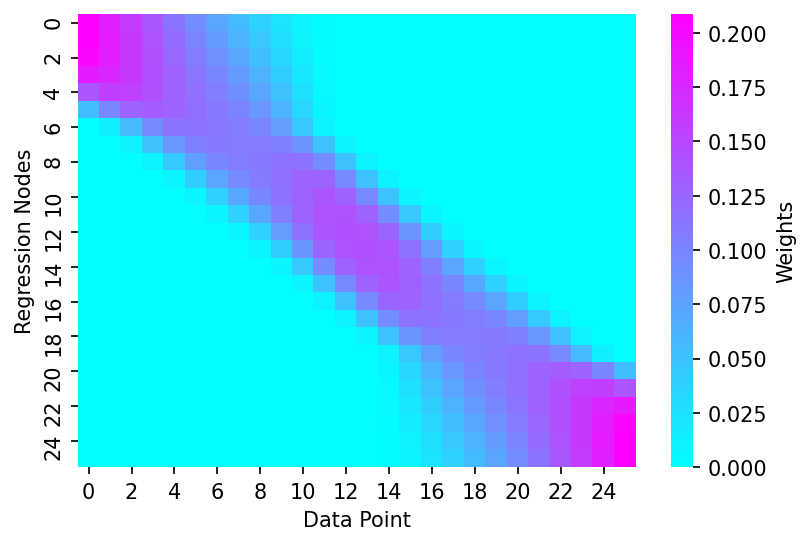

In [38]:
dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

However if we specify `num_fits` as 10 we can see that only 10 regression nodes are defined in the weights matrix

Text(69.58333333333334, 0.5, 'Regression Nodes')

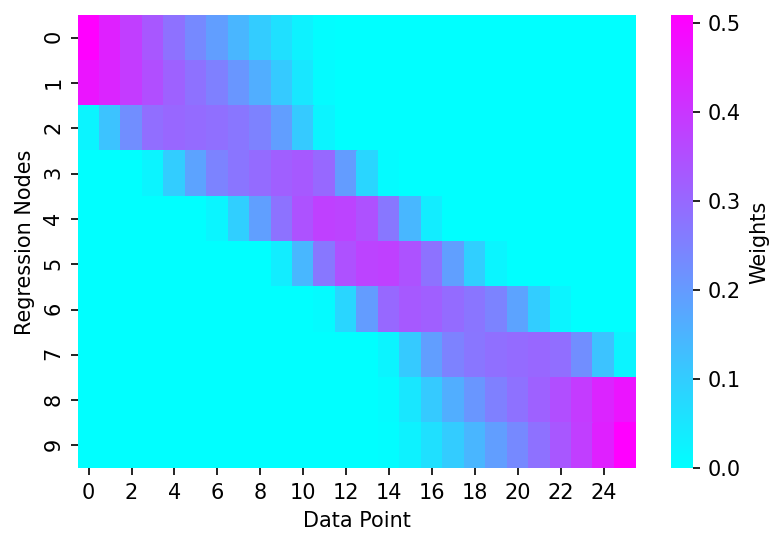

In [39]:
num_fits = 10

dist_matrix = create_dist_matrix(x, num_fits=num_fits)
dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

But what about if you were only really interested in getting highly localised regressions for a specific part of your variable space? Using the reg_anchors variable we can now specify our own grid over which to carry out the regressions.

Text(69.58333333333334, 0.5, 'Regression Nodes')

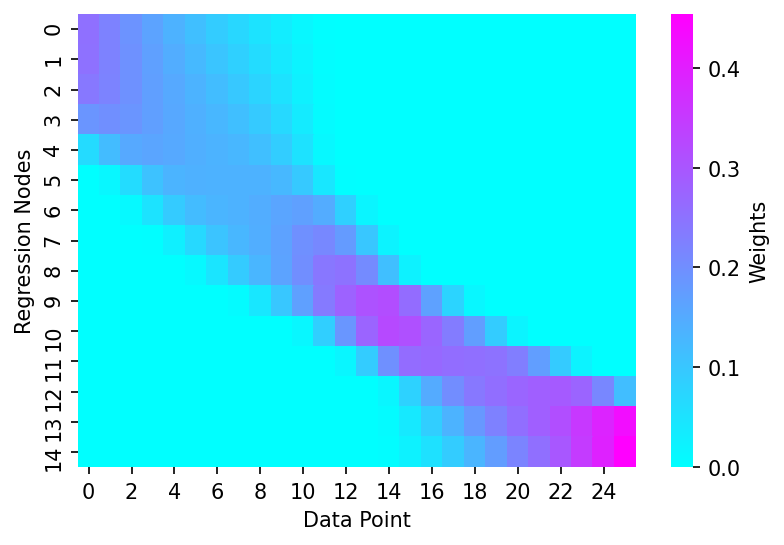

In [40]:
reg_anchors = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5])

dist_matrix = create_dist_matrix(x, reg_anchors=reg_anchors)
dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

We'll wrap these steps up in a couple of functions and add in some syntactic sugar to allow the user to more flexibily specify the distance matrix kwargs

In [41]:
#exports
def get_weights_matrix(x, frac=0.4, weighting_locs=None, reg_anchors=None, num_fits=None):
    frac_idx = get_frac_idx(x, frac)
    
    if weighting_locs is not None:
        dist_matrix = np.abs(weighting_locs - x.reshape(1, -1))
    else:
        dist_matrix = create_dist_matrix(x, reg_anchors=reg_anchors, num_fits=num_fits)
    
    dist_thresholds = get_dist_thresholds(x, frac_idx, dist_matrix)
    weights = dist_2_weights_matrix(dist_matrix, dist_thresholds)
    
    return weights

Text(69.58333333333334, 0.5, 'Regression Nodes')

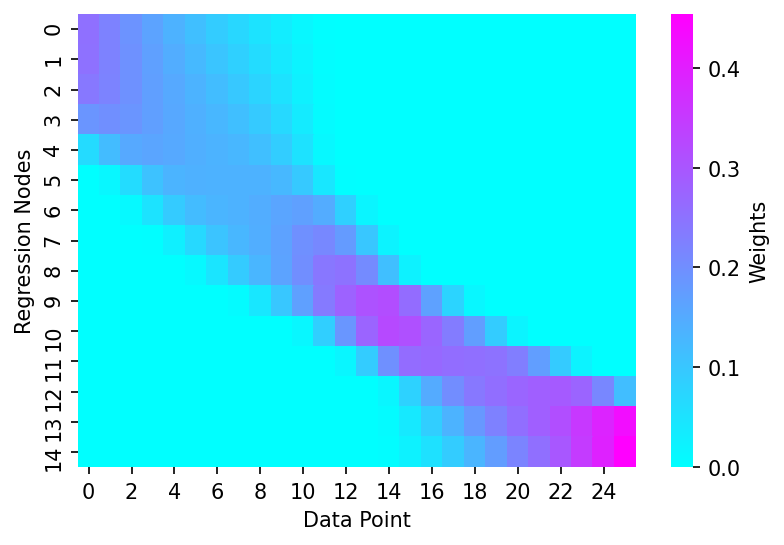

In [42]:
weights = get_weights_matrix(x, frac=0.5, reg_anchors=reg_anchors)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

We'll check this still works when we want to carry out a LOESS fit over all points

(26, 26)


Text(69.58333333333334, 0.5, 'Regression Nodes')

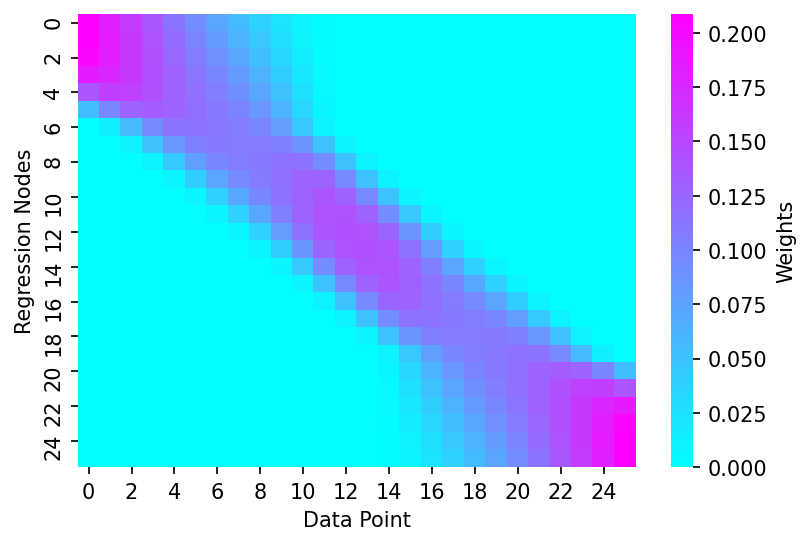

In [43]:
weights = get_weights_matrix(x, frac=frac)

print(weights.shape)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(weights, cmap='cool', cbar_kws={'label':'Weights'}, ax=ax)

ax.set_xlabel('Data Point')
ax.set_ylabel('Regression Nodes')

<br>

#### Regression

Now that we've calculated the weightings necessary for local regression we need to create the regression functions. We'll start by calculating the intercept and gradient of a linear regression fit with optional weighting.

In [44]:
#exports
def calc_lin_reg_betas(x, y, weights=None):
    if weights is None:
        weights = np.ones(len(x))
        
    b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
    A = np.array([[np.sum(weights), np.sum(weights * x)],
                  [np.sum(weights * x), np.sum(weights * x * x)]])
    
    betas = linalg.solve(A, b)
    
    return betas

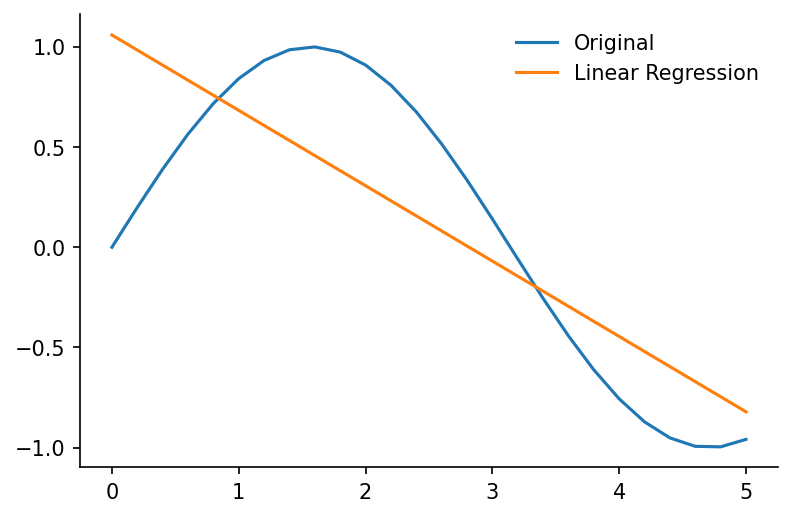

In [45]:
intercept, gradient = calc_lin_reg_betas(x, y)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x, y, label='Original')
ax.plot([x.min(), x.max()], [intercept+gradient*x.min(), intercept+gradient*x.max()], label='Linear Regression')

ax.legend(frameon=False)
hlp.hide_spines(ax)

<br>

We'll now repeat the regression calculation but will also specify a weighting for each data-point

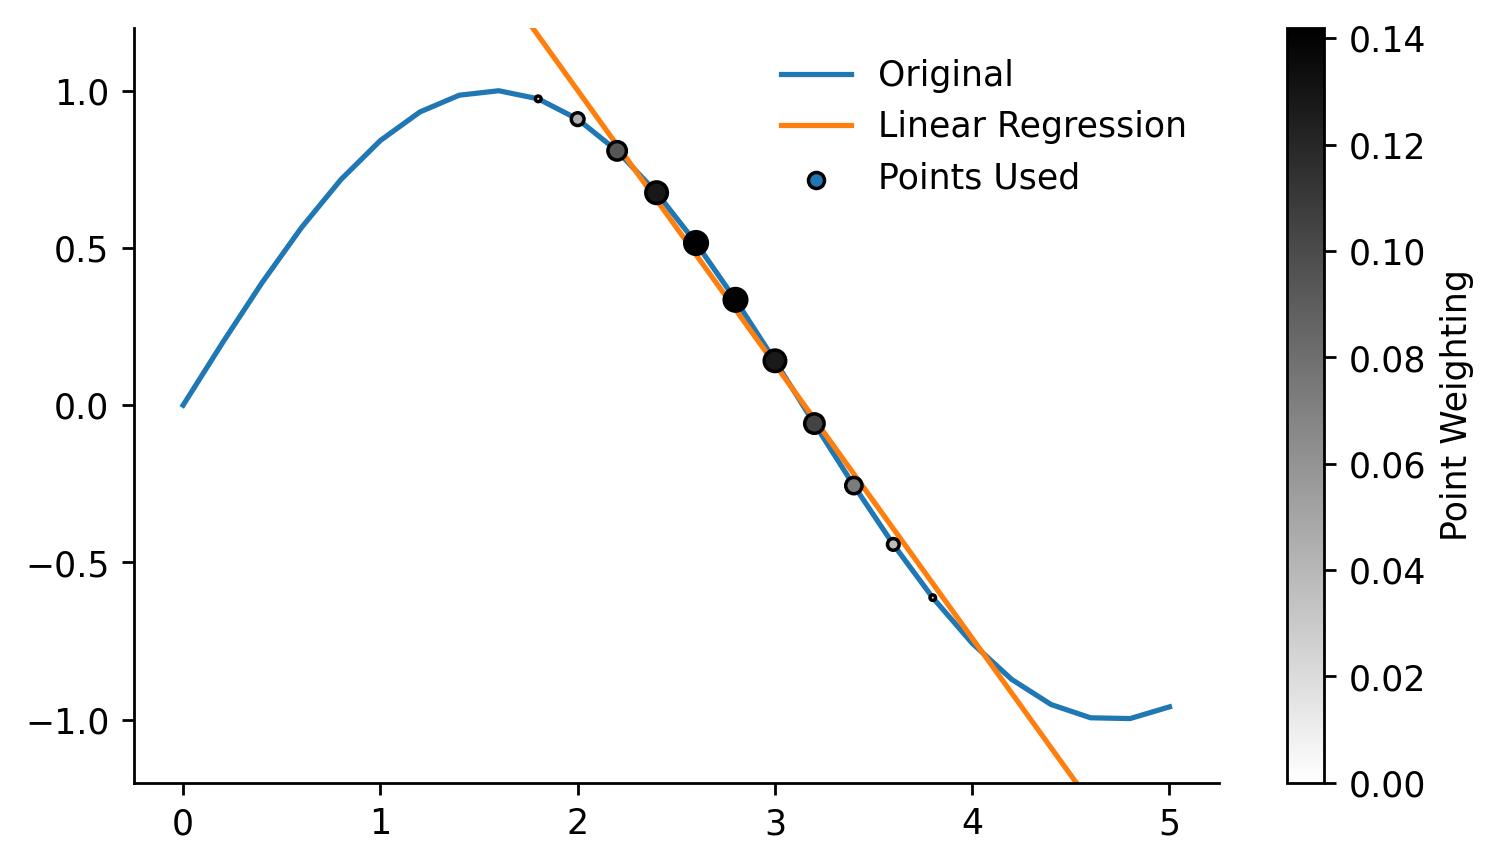

In [46]:
row_weights = weights[14, :]
intercept, gradient = calc_lin_reg_betas(x, y, row_weights)

x_used = x[x*row_weights>0]
y_used = y[x*row_weights>0]
x_weights = row_weights[x*row_weights>0]

## Plotting
fig, ax = plt.subplots(dpi=250, figsize=(7, 4))

weighted_points = ax.scatter(x, y, s=(row_weights)*300, c=row_weights, edgecolor='k', cmap='gray_r', label='Points Used', zorder=3, vmin=0)
cbar = fig.colorbar(weighted_points, label='Point Weighting')

ax.plot(x, y, label='Original')
ax.plot([x.min(), x.max()], [intercept+gradient*x.min(), intercept+gradient*x.max()], label='Linear Regression')

ax.set_ylim(-1.2, 1.2)
hlp.hide_spines(ax)

leg = ax.legend(frameon=False)

<br>

We can repeat this for all data-points

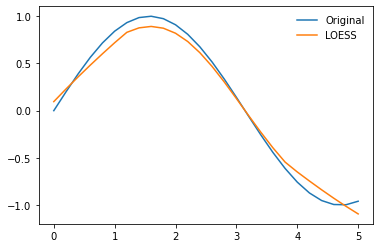

In [47]:
n = len(x)
y_pred = np.zeros(n)

for i in range(n):
    row_weights = weights[i, :]
    betas = calc_lin_reg_betas(x, y, weights[i, :])

    y_pred[i] = betas[0] + betas[1] * x[i]

plt.plot(x, y, label='Original')
plt.plot(x, y_pred, label='LOESS')
plt.legend(frameon=False)

<br>

Whilst this fit doesn't look great remember we can reduce the fraction of data used in each fit to get a more localised regression, in this example we'll also make use of the `num_fits` parameter to reduce the number of computations that are run.

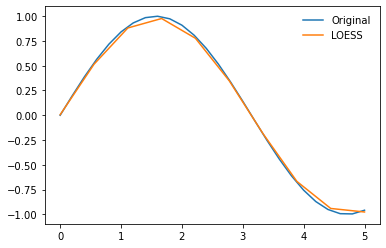

In [48]:
num_fits = 10

weights = get_weights_matrix(x, frac=0.2, num_fits=num_fits)

x_pred = num_fits_2_reg_anchors(x, num_fits).reshape(-1, 1)
y_pred = np.zeros(len(x_pred))

for i in range(len(x_pred)):
    row_weights = weights[i, :]
    betas = calc_lin_reg_betas(x, y, row_weights)

    y_pred[i] = betas[0] + betas[1] * x_pred[i]

plt.plot(x, y, label='Original')
plt.plot(x_pred, y_pred, label='LOESS')
plt.legend(frameon=False)

<br>

Rather than  carrying out the regression fitting and prediction together we'll seperate them to add some flexibility, for example we wouldnt be able to make predictions with a specified number of polynomial fits using the code we just wrote. 

For this fitting function we'll introduce a design matrix which will hold the coefficients for all of our regressions. We'll also make the function used for regression a parameter, this will allow us to replace it with other regression functions (e.g. polynomials) later on.

In [49]:
#exports
check_array = lambda array, x: np.ones(len(x)) if array is None else array

def fit_regressions(x, y, weights=None, reg_func=calc_lin_reg_betas, num_coef=2, **reg_params):
    if weights is None:
        weights = np.ones(len(x))
        
    n = weights.shape[0]
    
    y_pred = np.zeros(n)
    design_matrix = np.zeros((n, num_coef))
    
    for i in range(n):
        design_matrix[i, :] = reg_func(x, y, weights=weights[i, :], **reg_params)
        
    return design_matrix

In [50]:
weights = get_weights_matrix(x, frac=0.4, num_fits=10)
design_matrix = fit_regressions(x, y, weights)

design_matrix

array([[ 0.05905438,  0.73999059],
       [ 0.08020775,  0.6991559 ],
       [ 0.35324949,  0.41467757],
       [ 1.09720376, -0.10762239],
       [ 2.03581046, -0.58348682],
       [ 2.77888971, -0.88141726],
       [ 2.91594092, -0.92733431],
       [ 2.05244287, -0.68647646],
       [ 0.84017439, -0.38519789],
       [ 0.6033549 , -0.33232683]])

<br>

We can use this design matrix to create predictions for every local regression, then combine them based on their weightings

In [51]:
#exports
def lowess_fit_and_predict(x, y, frac=0.4, reg_anchors=None, num_fits=None, x_pred=None):
    weighting_locs = get_weighting_locs(x, reg_anchors=reg_anchors, num_fits=num_fits)
    weights = get_weights_matrix(x, frac=frac, weighting_locs=weighting_locs)
    design_matrix = fit_regressions(x, y, weights)
    
    if x_pred is None:
        x_pred = x

    point_evals = design_matrix[:, 0] + np.dot(x_pred.reshape(-1, 1), design_matrix[:, 1].reshape(1, -1))
    pred_weights = get_weights_matrix(x_pred, frac=frac, reg_anchors=weighting_locs)
    
    y_pred = np.multiply(pred_weights, point_evals.T).sum(axis=0)
    
    return y_pred

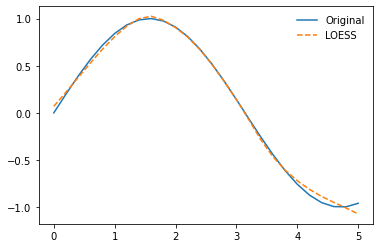

In [52]:
x = np.linspace(0, 5, num=26)
y = np.sin(x)

y_pred = lowess_fit_and_predict(x, y)

plt.plot(x, y, label='Original')
plt.plot(x, y_pred, '--', label='LOESS')
plt.legend(frameon=False)

<br>

If we pass an array to the `x_pred` parameter then those values will be used as the locations of the output predictions

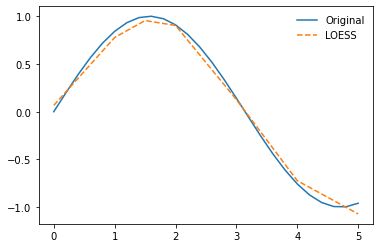

In [53]:
x_pred = np.array([0, 1, 1.5, 2, 3, 4, 5])
y_pred = lowess_fit_and_predict(x, y, num_fits=10, x_pred=x_pred)

plt.plot(x, y, label='Original')
plt.plot(x_pred, y_pred, '--', label='LOESS')
plt.legend(frameon=False)

<br>

Lets do some time tests, starting with a small dataset

In [54]:
x = np.linspace(0, 5, num=26)
y = np.sin(x)

In [55]:
%%timeit

y_pred = lowess_fit_and_predict(x, y)

3.93 ms ± 529 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br>

Even with larger datasets it remains performant

In [56]:
x = np.linspace(0, 5, num=3000)
y = np.sin(x)

frac = 0.1
x_pred = np.linspace(0, 5, 100)[1:] # to avoid divide by zero in MAPE calc

In [57]:
%%timeit

y_pred = lowess_fit_and_predict(x, y, frac=frac, x_pred=x_pred)

1.33 s ± 34.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

When making predictions with large datasets and low fractions we can achieve low error for the simple sin curve fitting example

In [58]:
y_pred = lowess_fit_and_predict(x, y, frac=frac, x_pred=x_pred)
y_true = np.sin(x_pred)

print(f'MAPE: {round(100*np.abs((y_true-y_pred)/y_true).mean(), 3)}%')

MAPE: 0.084%


<br>

### LOWESS on Real-World Data

We'll now evaluate the LOWESS fit on some real data, we'll start by loading the electric insights dataset

In [59]:
%%time

df_EI = eda.load_EI_df('../data/electric_insights.csv')

df_EI.head()

Wall time: 2.62 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

We'll start by extracting the X and y data

In [60]:
y_col = 'day_ahead_price'
X_cols = ['demand']

yX = df_EI['2020':][[y_col]+X_cols].dropna().values

y = yX[:, 0]
X = yX[:, 1:]

print(y.shape, X.shape)

(17435,) (17435, 1)


<br>

We'll then fit the model and make the prediction

In [61]:
%%time

x = X[:, 0]

x_pred = np.linspace(15, 55, 41)
y_pred = lowess_fit_and_predict(x, y, frac=0.4, num_fits=25, x_pred=x_pred)

Wall time: 73 ms


<br>

And now we can plot the results!

Text(0, 0.5, 'Day-Ahead Price (£/MWh)')

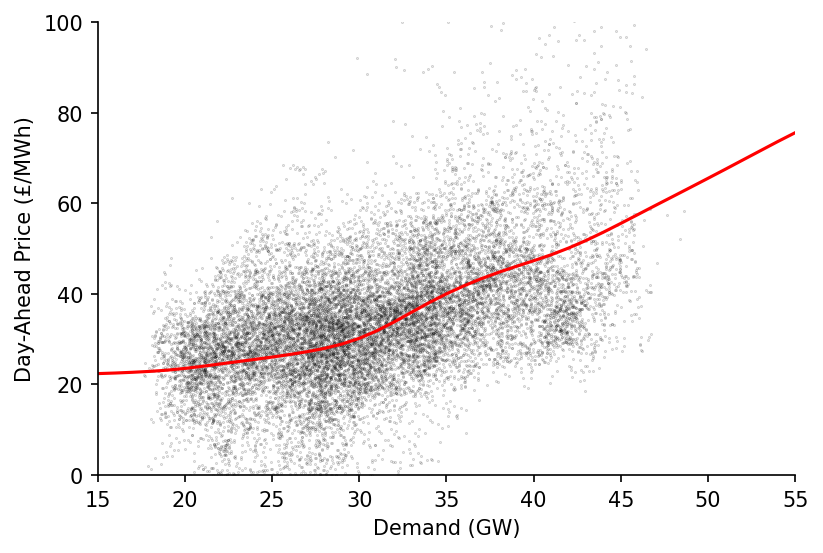

In [62]:
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, c='r')
ax.scatter(x, y, s=0.1, c='k', alpha=0.25)

ax.set_ylim(0, 100)
ax.set_xlim(15, 55)
hlp.hide_spines(ax)
ax.set_xlabel('Demand (GW)')
ax.set_ylabel('Day-Ahead Price (£/MWh)')

<br>

#### Robust Regression

What we've done so far is ultimately nothing more than an extension of linear regression, which has been achieved by fitting multiple regressions and manipulating the weighting of the data points used in each one.

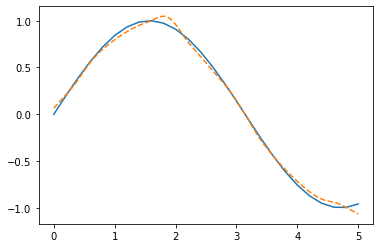

In [63]:
x = np.linspace(0, 5, num=26)
y = np.sin(x)

x_pred = np.linspace(0, 5, 100)
y_pred = lowess_fit_and_predict(x, y, num_fits=5, x_pred=x_pred)

plt.plot(x, y)
plt.plot(x_pred, y_pred, '--')

<br>

But we can also do much more with the weights, including adjusting them to make our regression more robust against outliers. First we'll create a new dataset which has some noise.

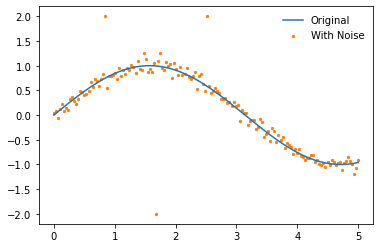

In [64]:
x = np.linspace(0, 5, num=150)
weights = get_weights_matrix(x, frac=0.2)

y = np.sin(x)
y_noisy = y + (np.random.normal(size=len(y)))/10

y_noisy[25] = 2
y_noisy[50] = -2
y_noisy[75] = 2

plt.plot(x, y, label='Original', zorder=2)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

We can use our `lowess_fit_and_predict` function to make a lowess model of this data

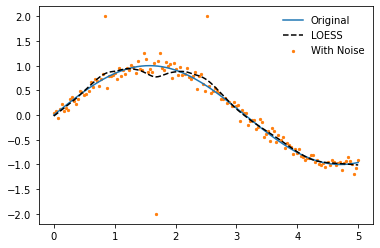

In [65]:
y_pred = lowess_fit_and_predict(x, y_noisy, frac=0.2, num_fits=25) 

plt.plot(x, y, label='Original', zorder=2)
plt.plot(x, y_pred, '--', label='LOESS', color='k', zorder=3)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

The issue though is that our model is being highly skewed by the outliers present in the data, robust regression provides a method to handle this (some improvements can also be made by increasing the `frac` value). To carry it out we need to repeat the lowess fit, but when we do we must further weight the data-points to minimize the influence of outliers.

> Robust regression is an iterative procedure that seeks to identify outliers and minimize their impact on the coefficient estimates - [NCSS](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Robust_Regression.pdf)

Cleveland, W. S. (1979) in his paper 'Robust Locally Weighted Regression and Smoothing Scatterplots' outlines a procedure for carrying out robust lowess regression that we will use here.

We'll start by calculating the standard deviation of the residuals.

In [66]:
residuals = y_noisy - y_pred
std_dev = np.quantile(np.abs(residuals), 0.682)

std_dev

0.09809846861289964

<br>

We can then define a threshold, say 6 standard deviations, and clip any values outside of that. We're left with a cleaned version of the residuals.

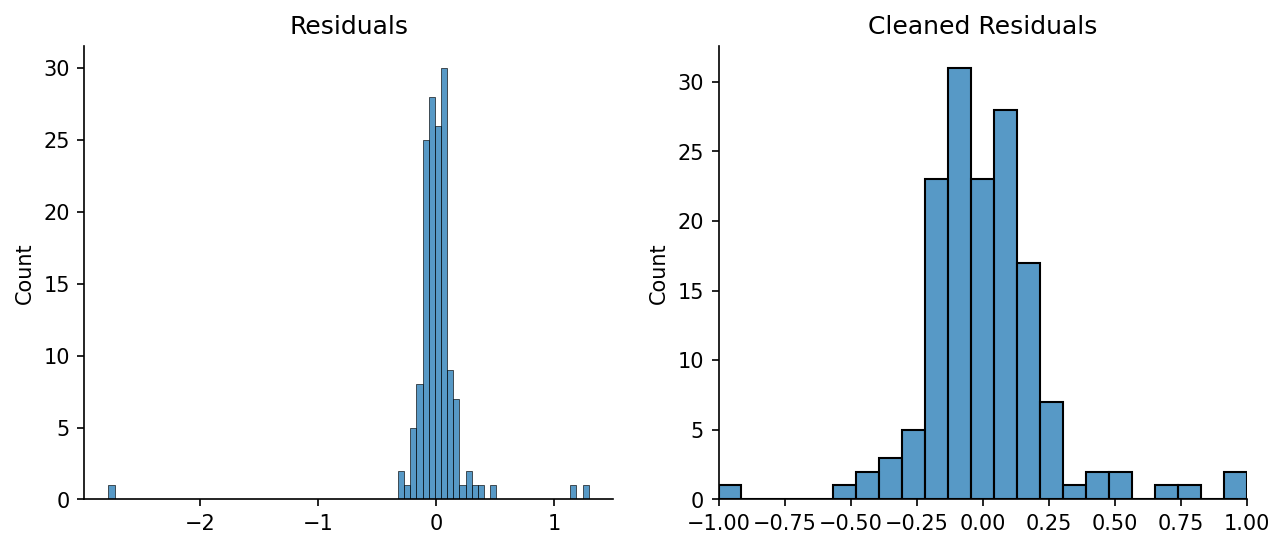

In [67]:
max_std_dev = 6

cleaned_residuals = np.clip(residuals / (max_std_dev * std_dev), -1, 1)

# Plotting
fig, axs = plt.subplots(dpi=150, ncols=2, figsize=(10, 4))

ax = axs[0]
sns.histplot(residuals, ax=ax)
ax.set_title('Residuals')

ax = axs[1]
sns.histplot(cleaned_residuals, ax=ax)
ax.set_xlim(-1, 1)
ax.set_title('Cleaned Residuals')

for ax in axs:
    hlp.hide_spines(ax)

<br>

In the last step we clipped all of our values from -1 to +1, that means if we square our values and deduct them from 1 any outliers will go to 0. The returned vector we'll call the `robust_weights`. 

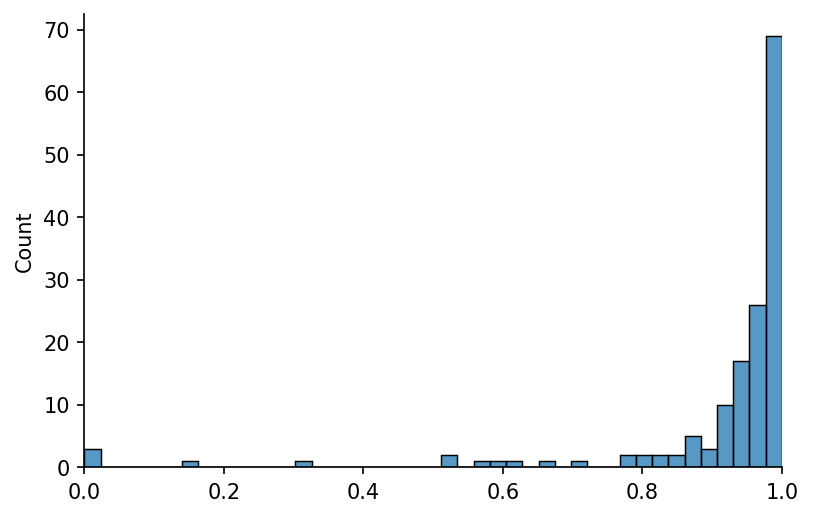

In [68]:
robust_weights = (1 - cleaned_residuals ** 2) ** 2

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(robust_weights, ax=ax)

ax.set_xlim(0, 1)
hlp.hide_spines(ax)

<br>

Before we move on we'll combine these into a single step for calculating the `robust_weights`

In [69]:
#exports
def calc_robust_weights(y, y_pred, max_std_dev=6):
    residuals = y - y_pred
    std_dev = np.quantile(np.abs(residuals), 0.682)

    cleaned_residuals = np.clip(residuals / (max_std_dev * std_dev), -1, 1)
    robust_weights = (1 - cleaned_residuals ** 2) ** 2
    
    return robust_weights

<br>

We'll now refactor our previous `lowess_fit_and_predict` but this time will enable it to carry out robust regressions

In [70]:
#exports
def robust_lowess_fit_and_predict(x, y, frac=0.4, reg_anchors=None, num_fits=None, x_pred=None, robust_weights=None, robust_iters=3):
    # Identifying the initial loading weights
    weighting_locs = get_weighting_locs(x, reg_anchors=reg_anchors, num_fits=num_fits)
    loading_weights = get_weights_matrix(x, frac=frac, weighting_locs=weighting_locs)
    
    # Robustifying the weights (to reduce outlier influence)
    if robust_weights is None:
        robust_loading_weights = loading_weights
    else:
        robust_loading_weights = np.multiply(robust_weights, loading_weights)
        robust_loading_weights = robust_loading_weights/robust_loading_weights.sum(axis=0)
        robust_loading_weights = np.where(~np.isfinite(robust_loading_weights), 0, robust_loading_weights)
    
    # Fitting the model and making predictions
    design_matrix = fit_regressions(x, y, robust_loading_weights)
    
    if x_pred is None:
        x_pred = x

    point_evals = design_matrix[:, 0] + np.dot(x_pred.reshape(-1, 1), design_matrix[:, 1].reshape(1, -1))
    pred_weights = get_weights_matrix(x_pred, frac=frac, reg_anchors=weighting_locs)
    
    y_pred = np.multiply(pred_weights, point_evals.T).sum(axis=0)
    
    # Recursive robust regression
    robust_weights = calc_robust_weights(y, y_pred)
    
    if robust_iters > 1:
        robust_iters -= 1
        y_pred = robust_lowess_fit_and_predict(x, y, frac=frac, reg_anchors=reg_anchors, num_fits=num_fits, x_pred=x_pred, robust_weights=robust_weights, robust_iters=robust_iters)
    
    return y_pred

<ipython-input-70-2d5390f2e121>:12: RuntimeWarning: invalid value encountered in true_divide
  robust_loading_weights = robust_loading_weights/robust_loading_weights.sum(axis=0)


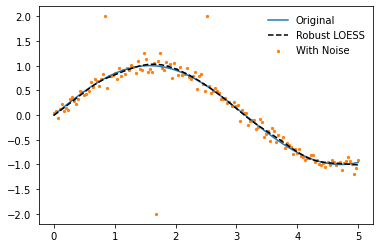

In [71]:
y_pred = robust_lowess_fit_and_predict(x, y_noisy, frac=0.2, num_fits=25) 

plt.plot(x, y, label='Original', zorder=2)
plt.plot(x, y_pred, '--', label='Robust LOESS', color='k', zorder=3)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

We've got everything working nicely but the current way we make predictions doesn't make it easy to plug-and-play with other Python libraries, to reduce this friction we'll refactor the code again and create a Scikit-Learn wrapper for our process.

In [72]:
#exports
class Lowess(BaseEstimator, RegressorMixin):
    def __init__(self, reg_func=calc_lin_reg_betas):
        self.reg_func = reg_func
        return
        
    def calculate_loading_weights(self, x, reg_anchors=None, num_fits=None, external_weights=None, robust_weights=None):
        # Calculating the initial loading weights
        weighting_locs = get_weighting_locs(x, reg_anchors=reg_anchors, num_fits=num_fits)
        loading_weights = get_weights_matrix(x, frac=self.frac, weighting_locs=weighting_locs)
        
        # Applying weight adjustments
        if external_weights is None:
            external_weights = np.ones(x.shape[0])
            
        if robust_weights is None:
            robust_weights = np.ones(x.shape[0])
        
        weight_adj = np.multiply(external_weights, robust_weights)
        loading_weights = np.multiply(weight_adj, loading_weights)
            
        # Post-processing weights
        loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising
        loading_weights = np.where(~np.isfinite(loading_weights), 0, loading_weights) # removing non-finite values
        
        self.weighting_locs = weighting_locs
        self.loading_weights = loading_weights
            
        return 
 
    def fit(self, x, y, frac=0.4, reg_anchors=None, num_fits=None, external_weights=None, robust_weights=None, robust_iters=3, **reg_params):
        self.frac = frac
        
        # Solving for the design matrix
        self.calculate_loading_weights(x, reg_anchors=reg_anchors, num_fits=num_fits, external_weights=external_weights, robust_weights=robust_weights)
        self.design_matrix = fit_regressions(x, y, weights=self.loading_weights, reg_func=self.reg_func, **reg_params)
    
        # Recursive robust regression
        if robust_iters > 1:
            y_pred = self.predict(x)
            robust_weights = calc_robust_weights(y, y_pred)
            
            robust_iters -= 1
            y_pred = self.fit(x, y, frac=self.frac, reg_anchors=reg_anchors, num_fits=num_fits, external_weights=external_weights, robust_weights=robust_weights, robust_iters=robust_iters, **reg_params)
            
            return y_pred
        
        return 
 
    def predict(self, x_pred):
        point_evals = self.design_matrix[:, 0] + np.dot(x_pred.reshape(-1, 1), self.design_matrix[:, 1].reshape(1, -1))
        pred_weights = get_weights_matrix(x_pred, frac=self.frac, reg_anchors=self.weighting_locs)

        y_pred = np.multiply(pred_weights, point_evals.T).sum(axis=0)
        
        return y_pred

<ipython-input-72-ce26aac552b5>:23: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


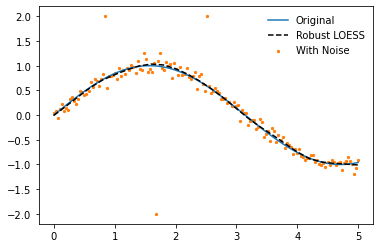

In [73]:
lowess = Lowess()
lowess.fit(x, y_noisy, frac=0.2)

x_pred = np.linspace(0, 5, 26)
y_pred = lowess.predict(x_pred)

# Plotting
plt.plot(x, y, label='Original', zorder=2)
plt.plot(x_pred, y_pred, '--', label='Robust LOESS', color='k', zorder=3)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

### Confidence Intervals

* Create the ensemble_results then take the specified confidence range
* Put into an sklearn wrapper

We're now able to take noisy data and find a robust estimate for the average value at any point, but what about uncertainty? In this work we'll look at two types of uncertainty quantification: confidence & prediction intervals. In this section we will discuss confidence intervals, summarised well in this statement:

> The selection of a confidence level for an interval determines the probability that the confidence interval produced will contain the true parameter value - [stat.yale.edu](http://www.stat.yale.edu/Courses/1997-98/101/confint.htm)

We'll start by creating a slightly noiser and longer sin curve than used previously.

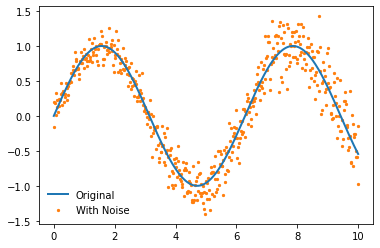

In [74]:
x = np.linspace(0, 10, num=500)
y = np.sin(x)

heteroskedasticity_factor = (1 + 2*np.array(range(len(x)))/len(x))/10
y_noisy = y + heteroskedasticity_factor*(np.random.normal(size=len(y)))

plt.plot(x, y, label='Original', linewidth=2, zorder=2)
plt.scatter(x, y_noisy, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)

<br>

To determine the confidence in our estimate we want to know how the model will perform against previously unseen data-points. We can randomly separate our data, calculate the error, then repeat many times to obtain a set of possible errors along the curve - this is a specific use-case of the more general bootstrapping approach.

To generate bootstrapped statistics we first need to split our data set, we'll begin by creating a function that returns the indexes for our in- and out-of-bag samples.

In [75]:
#exports
def get_bootstrap_idxs(x, bootstrap_bag_size=0.5):
    ## Bag size handling
    assert bootstrap_bag_size>0, 'Bootstrap bag size must be greater than 0'

    if bootstrap_bag_size > 1:
        assert int(bootstrap_bag_size) == bootstrap_bag_size, 'If the bootstrab bag size is not provided as a fraction then it must be an integer'

    else:
        bootstrap_bag_size = int(np.ceil(bootstrap_bag_size*len(x)))

    ## Splitting in-bag and out-of-bag samlpes
    idxs = np.array(range(len(x)))

    ib_idxs = np.sort(np.random.choice(idxs, bootstrap_bag_size, replace=True))
    oob_idxs = np.setdiff1d(idxs, ib_idxs)
    
    return ib_idxs, oob_idxs

In [76]:
ib_idxs, oob_idxs = get_bootstrap_idxs(x)

print(f'in-bag: {len(ib_idxs)}, out-of-bag: {len(oob_idxs)}')

in-bag: 250, out-of-bag: 303


In [77]:
#exports
def get_bootstrap_resid_std_devs(x, y, bag_size, model=Lowess(), **model_kwargs):
    # Splitting the in- and out-of-bag samples
    ib_idxs, oob_idxs = get_bootstrap_idxs(x, bag_size)

    x_ib, x_oob = x[ib_idxs], x[oob_idxs]
    y_ib, y_oob = y[ib_idxs], y[oob_idxs]

    # Fitting and predicting with the model
    model.fit(x_ib, y_ib, **model_kwargs)

    y_pred = model.predict(x)
    y_ib_pred = model.predict(x_ib)
    y_oob_pred = model.predict(x_oob)

    # Calculating the error
    y_ib_resids = y_ib - y_ib_pred
    ib_resid_std_dev = np.std(np.abs(y_ib_resids))

    y_oob_resids = y_oob - y_oob_pred
    oob_resid_std_dev = np.std(np.abs(y_oob_resids))

    return ib_resid_std_dev, oob_resid_std_dev

In [78]:
get_bootstrap_resid_std_devs(x, y, bag_size=0.5, frac=0.2, num_fits=20)

<ipython-input-72-ce26aac552b5>:23: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


(0.009035904437592581, 0.011323262668980446)

 [████████████████████████████████████████████████████████████] 1000/1000 [00:19<00:00, 0.02s/it]

Text(0.5, 0, "Residual's Standard Deviation")

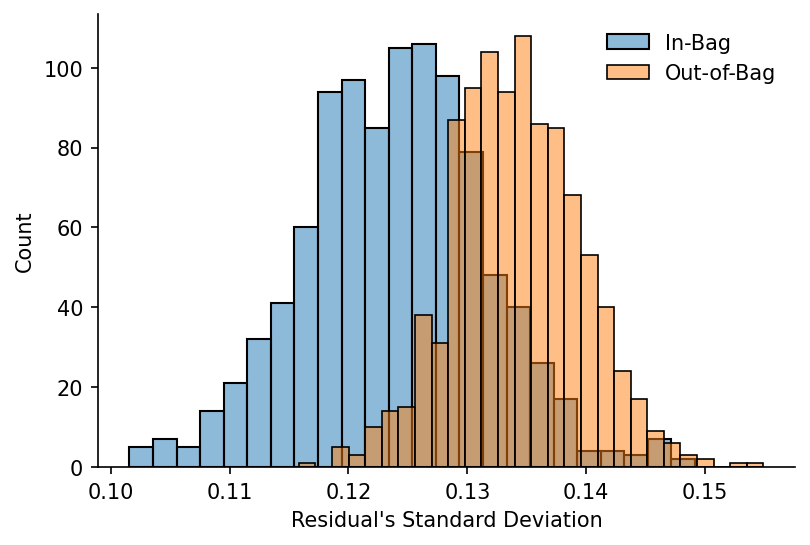

In [79]:
bag_size = 0.5
num_runs = 1000

ib_resid_std_devs = []
oob_resid_std_devs = []

for model_run in track(range(num_runs)):
    ib_resid_std_dev, oob_resid_std_dev = get_bootstrap_resid_std_devs(x, y_noisy, bag_size, frac=0.2, num_fits=20)
    
    ib_resid_std_devs += [ib_resid_std_dev]
    oob_resid_std_devs += [oob_resid_std_dev]
    
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(ib_resid_std_devs, ax=ax, alpha=0.5, label='In-Bag')
sns.histplot(oob_resid_std_devs, ax=ax, alpha=0.5, color='C1', label='Out-of-Bag')

ax.legend(frameon=False)
hlp.hide_spines(ax)
ax.set_xlabel('Residual\'s Standard Deviation')

In [80]:
#exports
def run_model(x, y, bag_size, model=Lowess(), x_pred=None, **model_kwargs):
    if x_pred is None:
        x_pred = x
        
    # Splitting the in- and out-of-bag samples
    ib_idxs, oob_idxs = get_bootstrap_idxs(x, bag_size)
    x_ib, y_ib = x[ib_idxs], y[ib_idxs]

    # Fitting and predicting the model
    model.fit(x_ib, y_ib, **model_kwargs)
    y_pred = model.predict(x_pred)
    
    return y_pred

def bootstrap_model(x, y, bag_size=0.5, model=Lowess(), x_pred=None, num_runs=1000, **model_kwargs):
    # Creating the ensemble predictions
    preds = []

    for bootstrap_run in track(range(num_runs)):
        y_pred = run_model(x, y, bag_size, model=model, x_pred=x_pred, **model_kwargs)
        preds += [y_pred]

    # Wrangling into a dataframe
    df_bootstrap = pd.DataFrame(preds, columns=x).T

    df_bootstrap.index.name = 'x'
    df_bootstrap.columns.name = 'bootstrap_run'

    return df_bootstrap

In [81]:
df_bootstrap = bootstrap_model(x, y_noisy, num_runs=1000, frac=0.2, num_fits=20)

df_bootstrap.head()

 [████████████████████████████████████████████████████████████] 1000/1000 [00:16<00:00, 0.02s/it]

bootstrap_run,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
x,,,,,,,,,,,,,,,,,,,,,
0.00000,0.148059,0.098818,0.075978,0.088295,0.081603,0.083997,0.061793,0.153973,0.063766,0.053202,...,0.038623,0.108865,0.113622,0.092095,0.074172,0.151637,0.130917,0.157930,0.145495,0.140873
0.02004,0.160024,0.112994,0.091569,0.102082,0.096711,0.098027,0.076264,0.165901,0.078446,0.067004,...,0.055571,0.122554,0.125669,0.105578,0.089170,0.163606,0.143671,0.170122,0.158754,0.153836
0.04008,0.171981,0.127143,0.107138,0.115852,0.111815,0.112045,0.090723,0.177814,0.093109,0.080794,...,0.072498,0.136232,0.137706,0.119051,0.104153,0.175566,0.156395,0.182305,0.171997,0.166788
0.06012,0.183930,0.141268,0.122688,0.129609,0.126916,0.126052,0.105170,0.189715,0.107758,0.094573,...,0.089405,0.149900,0.149734,0.132517,0.119123,0.187518,0.169091,0.194479,0.185226,0.179730
0.08016,0.195883,0.155371,0.138220,0.143396,0.142014,0.140048,0.119633,0.201620,0.122393,0.108395,...,0.106334,0.163583,0.161765,0.146015,0.134081,0.199462,0.181760,0.206647,0.198468,0.192664


In [82]:
#exports
def get_confidence_interval(df_bootstrap, conf_pct=0.95):
    conf_margin = (1 - conf_pct)/2
    df_conf_intvl = pd.DataFrame(columns=['min', 'max'], index=df_bootstrap.index)
    
    df_conf_intvl['min'] = df_bootstrap.quantile(conf_margin, axis=1)
    df_conf_intvl['max'] = df_bootstrap.quantile(1-conf_margin, axis=1)
    
    return df_conf_intvl

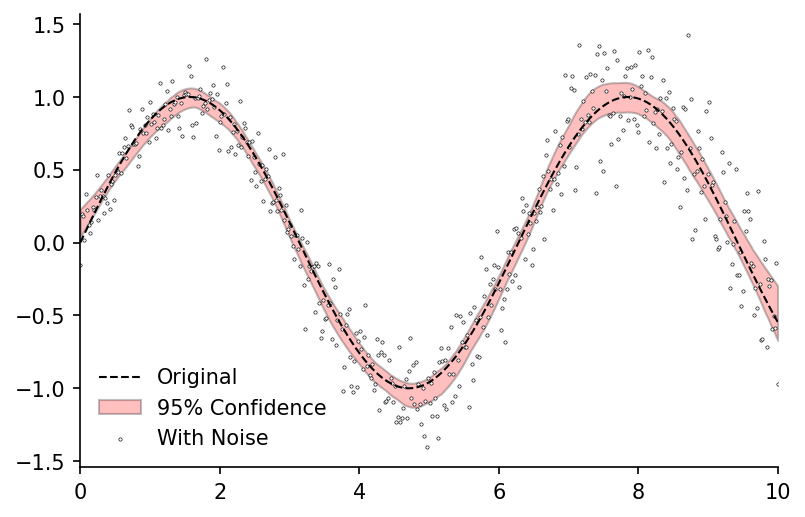

In [83]:
df_conf_intvl = get_confidence_interval(df_bootstrap, conf_pct=0.95)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x, y, 'k--', label='Original', linewidth=1, zorder=2)
ax.fill_between(df_conf_intvl.index, df_conf_intvl['min'], df_conf_intvl['max'], color='r', edgecolor='k', alpha=0.25, label='95% Confidence')
ax.scatter(x, y_noisy, label='With Noise', color='w', edgecolor='k', linewidth=0.3, s=2.5, zorder=1)

ax.legend(frameon=False)
ax.set_xlim(0, 10)
hlp.hide_spines(ax)

<br>

### Quantile Predictions

Earlier when creating our `Lowess` class we enabled the function used in calculating the design matrix betas to be specified at initialisation. We can now use this to pass a custom function that will calculate the design matrix for a local quantile regression.

In [84]:
#exports
def pred_to_quantile_loss(y, y_pred, q=0.5, weights=None):
    residuals = y - y_pred
    
    if weights is not None:
        residuals = weights*residuals
    
    loss = np.array([q*residuals, (q-1)*residuals]).max(axis=0).mean()
    
    return loss

def calc_quant_reg_loss(x0, x, y, q, weights=None):
    if weights is None:
        weights = np.ones(len(x))
        
    quantile_pred = x0[0] + x0[1]*x
    loss = pred_to_quantile_loss(y, quantile_pred, q, weights)
    
    return loss

calc_quant_reg_betas = lambda x, y, q=0.5, x0=np.zeros(2), weights=None, method='nelder-mead': minimize(calc_quant_reg_loss, x0, method=method, args=(x, y, q, weights)).x

<br>

We'll then create a wrapper that will fit the model for several specified quantiles

In [85]:
#exports
def quantile_model(x, y, model=Lowess(calc_quant_reg_betas), 
                   x_pred=None, qs=np.linspace(0.1, 0.9, 9), **model_kwargs):

    if x_pred is None:
        x_pred = np.sort(np.unique(x))
        
    q_to_preds = dict()

    for q in track(qs):
        model.fit(x, y, q=q, **model_kwargs)
        q_to_preds[q] = model.predict(x_pred)

    df_quantiles = pd.DataFrame(q_to_preds, index=x_pred)
    
    df_quantiles.index.name = 'x'
    df_quantiles.columns.name = 'quantiles'

    return df_quantiles

In [86]:
%%time

df_quantiles = quantile_model(x, y_noisy, frac=0.2, num_fits=100, robust_iters=1)

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 9/9 [00:09<00:01, 1.03s/it]

Wall time: 9.29 s


quantiles,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
x,,,,,,,,,
0.00000,-0.021958,-0.005469,0.053930,0.124141,0.141889,0.159734,0.162492,0.187253,0.279464
0.02004,-0.008701,0.008818,0.067634,0.136758,0.155080,0.172907,0.176402,0.201699,0.293552
0.04008,0.004544,0.023092,0.081323,0.149367,0.168257,0.186077,0.190310,0.216151,0.307642
0.06012,0.017791,0.037371,0.095010,0.161975,0.181434,0.199263,0.204236,0.230621,0.321745
0.08016,0.031046,0.051664,0.108699,0.174586,0.194623,0.212476,0.218189,0.245114,0.335864


<br>

We can visualise the range of our predictions

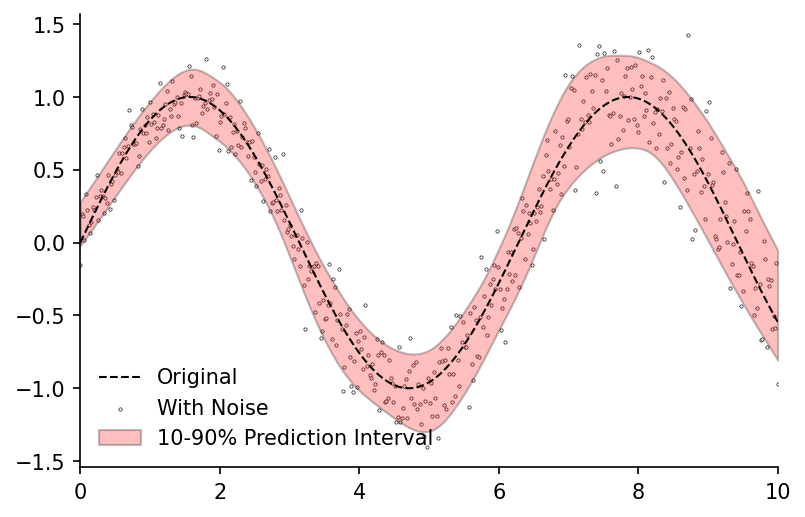

In [87]:
fig, ax = plt.subplots(dpi=150)

ax.plot(x, y, 'k--', label='Original', linewidth=1, zorder=2)
ax.scatter(x, y_noisy, label='With Noise', color='w', edgecolor='k', linewidth=0.3, s=2.5, zorder=1)
ax.fill_between(df_quantiles.index, df_quantiles[0.1], df_quantiles[0.9], color='r', edgecolor='k', alpha=0.25, label='10-90% Prediction Interval')

ax.legend(frameon=False, loc=3)
ax.set_xlim(0, 10)
hlp.hide_spines(ax)

<br>

### Quantile LOWESS on Real-World Data

In this example we'll use power output data from Portugese hydro-plants

In [88]:
df_portugal_hydro = pd.read_csv('../data/lowess_examples/portugese_hydro.csv')

df_portugal_hydro.index = pd.to_datetime(df_portugal_hydro['datetime'])
df_portugal_hydro = df_portugal_hydro.drop(columns='datetime')

df_portugal_hydro['day_of_the_year'] = df_portugal_hydro.index.dayofyear
df_portugal_hydro = df_portugal_hydro.resample('D').mean()
df_portugal_hydro = df_portugal_hydro.rename(columns={'power_MW': 'average_power_MW'})

df_portugal_hydro.head()

,average_power_MW,day_of_the_year
datetime,,
2015-01-01,698.500000,1
2015-01-02,1065.750000,2
2015-01-03,905.125000,3
2015-01-04,795.708333,4
2015-01-05,1141.625000,5


<br>

We now just need to feed this data into our `quantile_model` wrapper

In [89]:
# Estimating the quantiles
df_quantiles = quantile_model(df_portugal_hydro['day_of_the_year'].values, 
                              df_portugal_hydro['average_power_MW'].values, 
                              frac=0.4, num_fits=40)

# Cleaning names and sorting for plotting
df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
df_quantiles = df_quantiles[df_quantiles.columns[::-1]]

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 9/9 [00:26<00:03, 2.86s/it]

,p90,p80,p70,p60,p50,p40,p30,p20,p10
x,,,,,,,,,
1,1885.079172,1400.781601,1006.972631,910.768786,795.474566,693.000758,604.221026,498.095705,407.170002
2,1885.932585,1406.291952,1015.762933,917.073552,800.254803,697.120909,607.520973,500.673220,409.021489
3,1886.799899,1411.805229,1024.541485,923.369568,805.008381,701.225043,610.814367,503.239239,410.866080
4,1887.680853,1417.321378,1033.310416,929.659353,809.738103,705.316516,614.104565,505.797108,412.694541
5,1888.568977,1422.837956,1042.075556,935.951679,814.455951,709.409014,617.404051,508.358906,414.485478


<br>

We can then visualise the estimated quantile fits of the data

(0.0, 2620.8375)

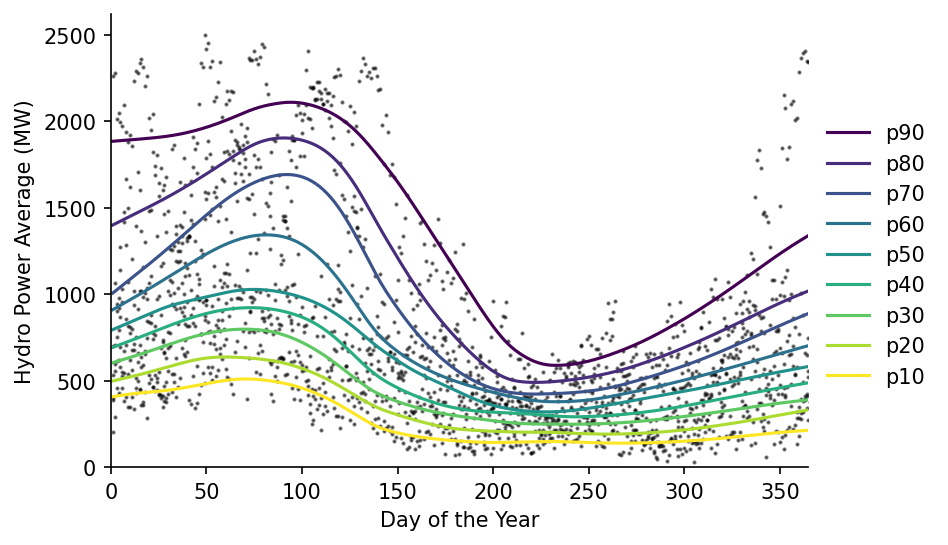

In [90]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_portugal_hydro['day_of_the_year'], df_portugal_hydro['average_power_MW'], s=1, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Hydro Power Average (MW)')
ax.set_xlim(0, 365)
ax.set_ylim(0)

<br>

We can also ask questions like: "what day of a standard year would the lowest power output be recorded?"

In [91]:
scenario = 'p50'

print(f'In a {scenario} year the lowest hydro power output will most likely fall on day {df_quantiles[scenario].idxmin()}')

In a p50 year the lowest hydro power output will most likely fall on day 228


<br>

### Quantile Lowess for Data Cleaning

In this section we'll look at how we can use our Lowess methods to process some wind turbine SCADA data to produce a clean power curve that doesn't include under-powered periods.

We'll start by loading the data in.

In [92]:
df_SCADA = pd.read_csv('../data/lowess_examples/turbine_SCADA.csv')

df_SCADA.head(3)

,UTC,T01_active_power,T01_blade_pitch,T01_generator_speed,T01_wind_speed,T02_active_power,T02_blade_pitch,T02_generator_speed,T02_wind_speed,T03_active_power,...,T09_theoretical_power,T10_theoretical_power,T11_theoretical_power,T12_theoretical_power,T13_theoretical_power,T14_theoretical_power,T15_theoretical_power,T16_theoretical_power,pc_error,wind_angle_rad
0,2017-09-30 18:26:40,56.0,-0.4,573.0,4.51,-4.0,5.2,682.0,2.21,-41.0,...,163.0,0.0,23.32,101.26,121.42,32.33,54.88,93.42,838.636286,NaN
1,2017-09-30 18:56:40,56.0,-0.4,573.0,4.51,-4.0,5.2,682.0,2.21,-41.0,...,163.0,0.0,23.32,101.26,121.42,32.33,54.88,93.42,838.636286,NaN
2,2017-09-30 19:26:40,56.0,-0.4,573.0,4.51,-4.0,5.2,682.0,2.21,-41.0,...,163.0,0.0,23.32,101.26,121.42,32.33,54.88,93.42,838.636286,NaN


<br>

We'll extract data for a single turbine

In [93]:
filter_for_turbine = lambda df, turbine=1: df[['UTC', f'T{str(turbine).zfill(2)}_active_power', f'T{str(turbine).zfill(2)}_wind_speed', 'wind_angle_rad']].pipe(lambda df: df.rename(columns=dict(zip(df.columns, df.columns.str.replace(f'T{str(turbine).zfill(2)}_', '')))))

df_turbine = filter_for_turbine(df_SCADA, 15).dropna()

df_turbine.head()

,UTC,active_power,wind_speed,wind_angle_rad
12,2017-10-01 00:26:40,68.0,4.396667,-1.035572
13,2017-10-01 00:56:40,112.5,3.690000,-0.969684
14,2017-10-01 01:26:40,238.0,4.670000,0.395575
15,2017-10-01 01:56:40,494.0,7.140000,-1.460979
16,2017-10-01 02:26:40,562.0,5.370000,0.493009


<br>

We'll then try and fit a Lowess estimate for the power curve.

Wall time: 823 ms


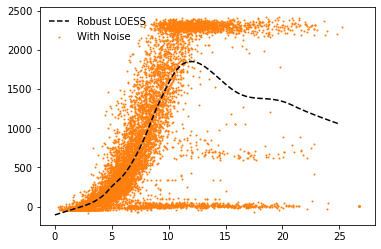

In [94]:
%%time

x = df_turbine['wind_speed'].values
y = df_turbine['active_power'].values

lowess = Lowess()
lowess.fit(x, y, frac=0.2, num_fits=100)

x_pred = np.linspace(0, 25, 101)
y_pred = lowess.predict(x_pred)

# Plotting
plt.plot(x_pred, y_pred, '--', label='Robust LOESS', color='k', zorder=3)
plt.scatter(x, y, label='With Noise', color='C1', s=1, zorder=1)
plt.legend(frameon=False)

<br>

Unfortunately the fit is thrown by the large number of occurences where the farm is under-powered or set to output 0, we want to remove these so that we can estimate the 'standard' power curve. We'll create a quantile Lowess fit to see if that helps us understand the data any better.

In [95]:
# Estimating the quantiles
df_quantiles = quantile_model(x, y, frac=0.2, qs=np.linspace(0.025, 0.975, 41), num_fits=40)

# Cleaning names and sorting for plotting
df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
df_quantiles = df_quantiles[df_quantiles.columns[::-1]]

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 41/41 [03:23<00:05, 4.94s/it]

<ipython-input-72-ce26aac552b5>:23: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


,p97,p95,p92,p90,p88,p85,p83,p80,p78,p76,...,p23,p21,p19,p16,p14,p12,p9,p7,p4,p2
x,,,,,,,,,,,,,,,,,,,,,
0.25,-31.860696,-36.669048,-49.591663,-50.801088,-54.897896,-62.434574,-65.669749,-68.233124,-68.978879,-69.727429,...,-79.596249,-74.346266,-69.082512,-62.705295,-58.361960,-53.923307,-50.093880,-49.133993,-50.204981,-51.814971
0.33,-25.204007,-31.291942,-44.473507,-46.183799,-50.499260,-58.150837,-61.482390,-64.178519,-65.075525,-65.957103,...,-78.243608,-73.379886,-68.427162,-62.365775,-58.143574,-53.878093,-50.080810,-49.060602,-49.981424,-51.572415
0.41,-18.657741,-25.989947,-39.441039,-41.631715,-46.156123,-53.916891,-57.338453,-60.163005,-61.208625,-62.225847,...,-76.897035,-72.414257,-67.779658,-62.049403,-57.951227,-53.851247,-50.079145,-49.001349,-49.757637,-51.331687
0.49,-12.175776,-20.724678,-34.459209,-37.113204,-41.840145,-49.706321,-53.214941,-56.164650,-57.357093,-58.512929,...,-75.543285,-71.435088,-67.123936,-61.737423,-57.768214,-53.828890,-50.079421,-48.949263,-49.532682,-51.092106
0.57,-5.711144,-15.457152,-29.492201,-32.596020,-37.522486,-45.492376,-49.088458,-52.161221,-53.499585,-54.797276,...,-74.169096,-70.428227,-66.444072,-61.411097,-57.577766,-53.797131,-50.072217,-48.897306,-49.305623,-50.852972


<br>

Plotting these we can see an interesting relationship, where for many of the lower quantiles the estimate peaks then quickly drops to around 0. It is the area below and to the right of these peaks that we want to remove from our power curve estimate.

(0.0, 2715.0737814101485)

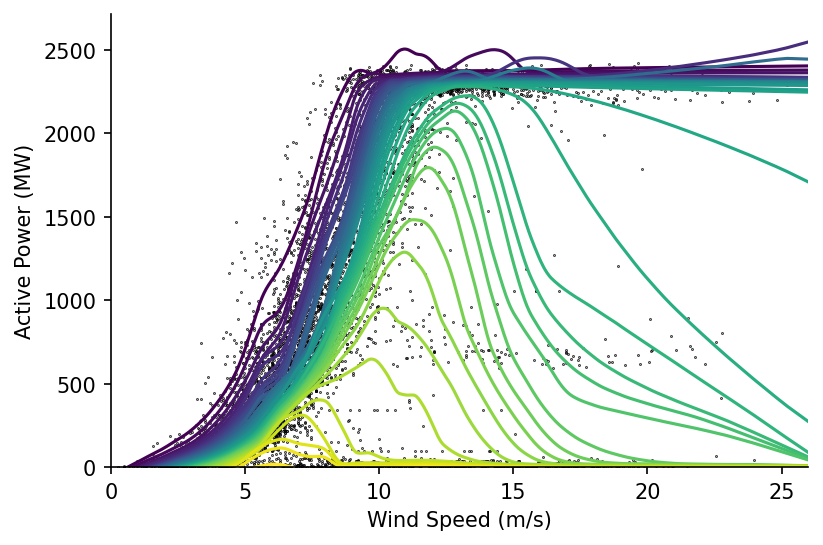

In [96]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(x, y, s=0.1, color='k', alpha=1)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
#ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Active Power (MW)')
ax.set_xlim(0, 26)
ax.set_ylim(0)

<br>

We'll first identify the ratio between the peak value and the final value (above speeds of 25 m/s). We'll then remove points after the peak where the ratio between their peak and final values exceeds a defined threshold (in our case 2).

N.b. there's probably a much nicer way to do this where the for loop isn't needed, this would be handy to implement as it would be good to have a vector containing all of the indexes that have been removed.

In [97]:
exceeded_quantiles = ((df_quantiles.max()/df_quantiles.iloc[-1].clip(0.1) > 2)
                      .replace(False, np.nan)
                      .dropna()
                      .index
                     )

s_maxs = df_quantiles[exceeded_quantiles].max()
s_idxmaxs = df_quantiles[exceeded_quantiles].idxmax()

cleaned_x = x
cleaned_y = y

for exceeded_quantile in exceeded_quantiles:
    min_x = s_idxmaxs[exceeded_quantile]
    max_y = s_maxs[exceeded_quantile]
    
    idxs_to_remove = (cleaned_x > min_x) & (cleaned_y < max_y)

    cleaned_x = cleaned_x[~idxs_to_remove]
    cleaned_y = cleaned_y[~idxs_to_remove]

<br>

Visualising the results we can clearly see that the unwanted periods have been removed

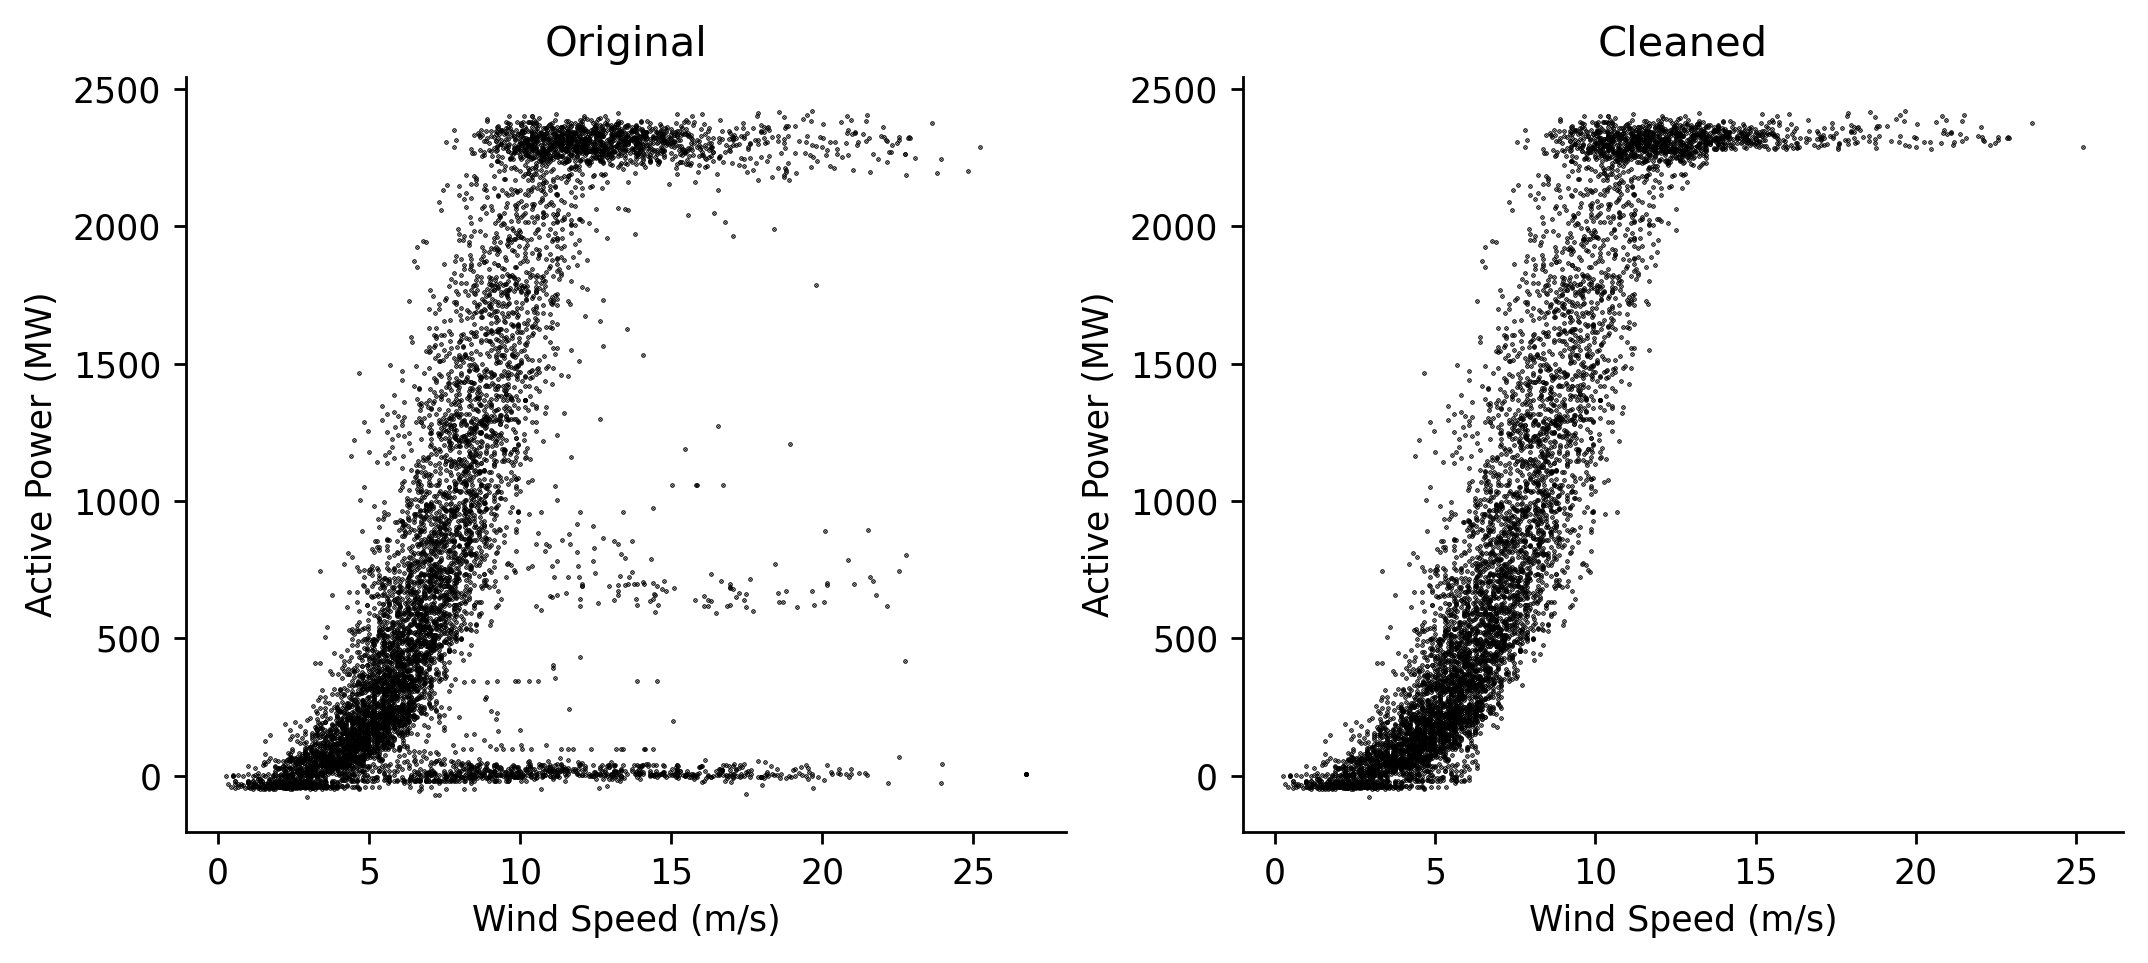

In [98]:
fig, axs = plt.subplots(dpi=250, ncols=2, figsize=(10, 4))

axs[0].scatter(x, y, s=0.1, color='k', alpha=1)
axs[1].scatter(cleaned_x, cleaned_y, s=0.1, color='k', alpha=1)

axs[0].set_title('Original')
axs[1].set_title('Cleaned')

for ax in axs:
    hlp.hide_spines(ax)
    ax.set_xlabel('Wind Speed (m/s)')
    ax.set_ylabel('Active Power (MW)')

<br>

We're now ready to make our power curve lowess estimate again

<ipython-input-72-ce26aac552b5>:23: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


Wall time: 755 ms


Text(0, 0.5, 'Active Power (MW)')

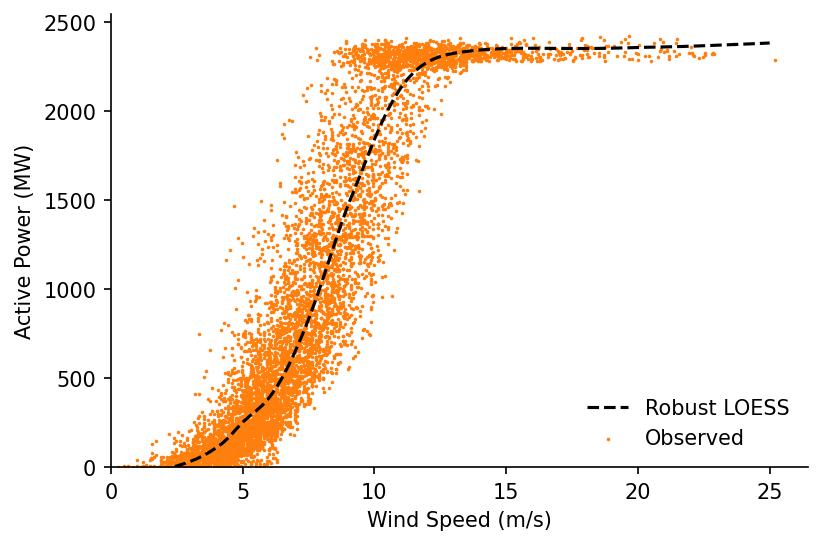

In [99]:
%%time

lowess = Lowess()
lowess.fit(cleaned_x, cleaned_y, frac=0.2, num_fits=100)

x_pred = np.linspace(0, 25, 101)
y_pred = lowess.predict(x_pred)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x_pred, y_pred, '--', label='Robust LOESS', color='k', zorder=3)
ax.scatter(cleaned_x, cleaned_y, label='Observed', color='C1', s=0.5, zorder=1)

ax.legend(frameon=False)
hlp.hide_spines(ax)
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Active Power (MW)')

In [100]:
# Clip y to something like 0.01, just needs to be marginally above 0
# Should check what happens to the lower part though, because of frac the neg values may be helping
# What happens if I fit for data where power<2250 and speed<14
# Could then have a seperate distribution fit for the period after
# Could then use weights to transition between them
# Inspecting the active power spikes for the removed values should identify set-points

<br>

### External Weights

(-25.0, 100.0)

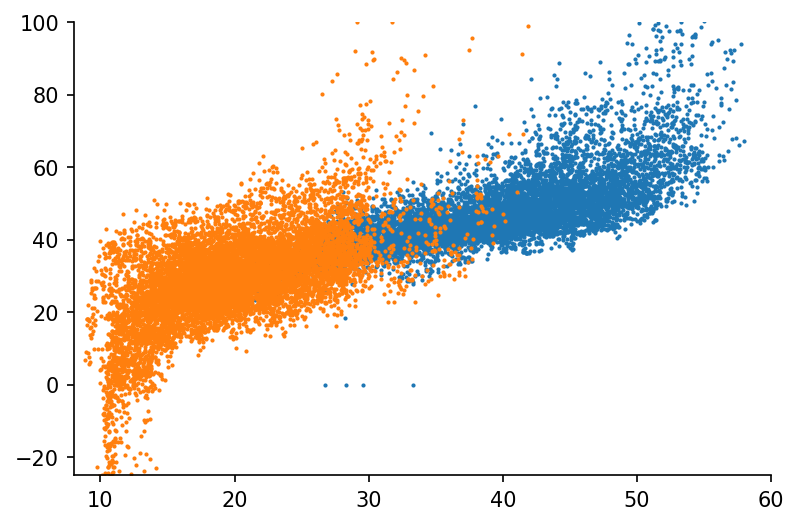

In [101]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)

<br>

Lets start by adding some boolean filters that we'll then cast as integers to act as weights, for one we'll choose an early winter period from the dataset, for the other we'll take the latest summer

In [102]:
model_to_dt_weights = {
    'Winter 10-11': ((s_dispatchable.index < '2011-03') & (s_dispatchable.index > '2010-09')).astype(int),
    'Summer 20': ((s_dispatchable.index < '2020-09') & (s_dispatchable.index > '2020-03')).astype(int)
}

df_preds = pd.DataFrame()

for model_name, dt_weights in model_to_dt_weights.items():
    lowess = Lowess()
    lowess.fit(s_dispatchable.values, s_price.values, frac=0.3, num_fits=31, external_weights=dt_weights)

    x_pred = np.linspace(8, 60, 53)
    y_pred = lowess.predict(x_pred)

    df_preds[model_name] = pd.Series(y_pred, index=x_pred)

<ipython-input-72-ce26aac552b5>:23: RuntimeWarning: invalid value encountered in true_divide
  loading_weights = loading_weights/loading_weights.sum(axis=0) # normalising


Text(0, 0.5, 'Price (£/MWh)')

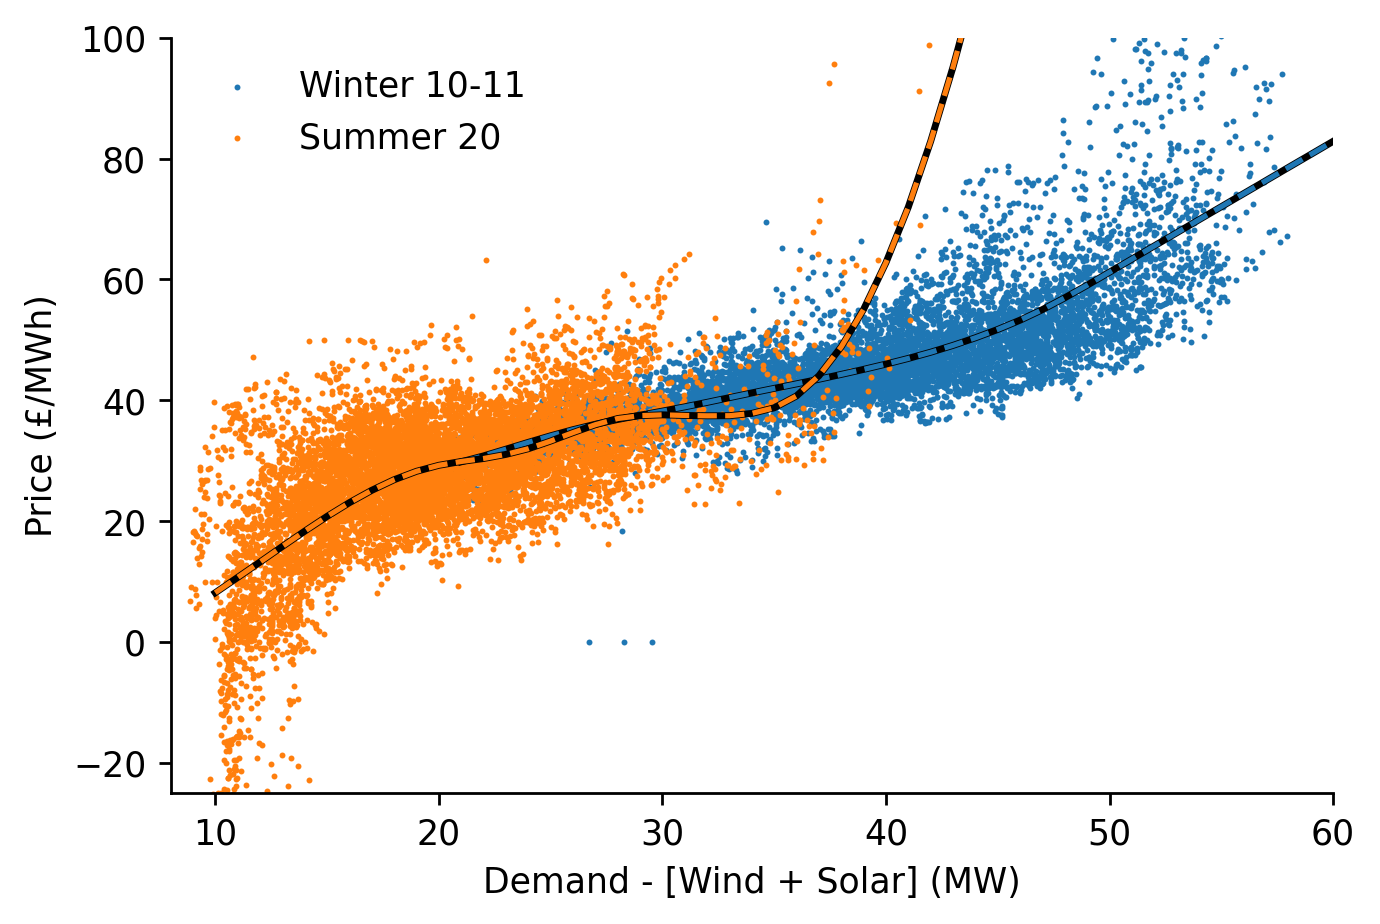

In [103]:
fig, ax = plt.subplots(dpi=250)

for i, (model_name, dt_weights) in enumerate(model_to_dt_weights.items()):
    color = f'C{i}'
    ax.scatter(s_dispatchable[dt_weights.astype(bool)], s_price[dt_weights.astype(bool)], color=color, s=0.5, label=model_name)
    
    min_, max_ = s_dispatchable[dt_weights.astype(bool)].quantile([0.001, 0.99])
    df_preds.loc[df_preds.index>min_, model_name].plot(ax=ax, color='k', linewidth=2, label='_nolegend_')
    df_preds.loc[df_preds.index>min_, model_name].plot(ax=ax, color=color, linestyle='--', label='_nolegend_')

ax.legend(frameon=False)
hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

In [104]:
# Want it to be fuzzy not discrete
# We now want to define a frac and do a similar sort of weighting to earlier (tri-cube kernel)
# perhaps could make the distance to weight calc modular

# Need to be able to input a date and an x value then get a prediction

In [124]:
#exports
def calc_timedelta_dists(dates, central_date, threshold_value=24, threshold_units='W'):
    timedeltas = pd.to_datetime(dates, utc=True) - pd.to_datetime(central_date, utc=True)
    timedelta_dists = timedeltas/pd.Timedelta(value=threshold_value, unit=threshold_units)

    return timedelta_dists

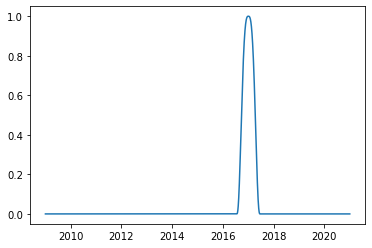

In [125]:
central_date = '2017-01-01'

timedelta_dists = calc_timedelta_dists(df_EI.index, central_date)
weights = dist_to_weights(timedelta_dists.values)

plt.plot(df_EI.index, weights)

Wall time: 5.6 s


<AxesSubplot:ylabel='local_datetime'>

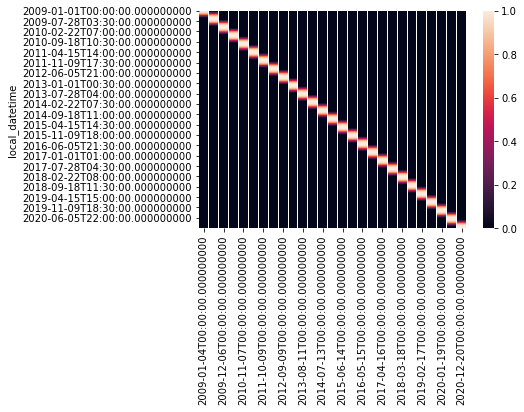

In [127]:
%%time

reg_dates = pd.date_range(df_EI.index.min(), df_EI.index.max(), freq='24W')

df_timedeltas = pd.DataFrame(index=df_EI.index, columns=reg_dates)

for reg_date in reg_dates:
    df_timedeltas[reg_date] = pd.Series(calc_timedelta_dists(df_EI.index, reg_date)).pipe(dist_to_weights).values
    
sns.heatmap(df_timedeltas)

In [110]:
# could use the external weights to also carry out cross validation by adding a filter for the idxs
# Clip y to something like 0.01, just needs to be marginally above 0
# Should check what happens to the lower part though, because of frac the neg values may be helping
# What happens if I fit for data where power<2250 and speed<14
# Could then have a seperate distribution fit for the period after
# Could then use weights to transition between them
# Inspecting the active power spikes for the removed values should identify set-points

In [111]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-eda.ipynb.
Converted 03-lowess.ipynb.
